# Previsão de notas de alunos por meio de Árvore de Decisão

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

## 1 - Carregando Base de Dados

In [2]:
df = pd.read_csv("student-mat.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## 2 - Preparação dos dados

In [4]:
# Verificando a existêcia de valores nulos
df.isnull().values.any()

False

### Vamos considerar todas as variáveis como preditoras, exceto as variáveis G1, G2 e G3, uma vez que por meio delas, será criada uma variável target com base na média das três grades:

- Nota A se acima de 90% da média

- Nota B se entre 50% e 90% da média

- Nota C se abaixo de 50% da média

In [5]:
# Criando um atributo média
df['gradeAv'] = (df['G1'] + df['G2'] + df['G3']) / 3

In [6]:
# Classificando notas com base nos critérios anterioremente comentados
def define_grade(data):
    # Cria lista para armazenar dados
    grades = []

    for row in data['gradeAv']:
        # Se nota maior que 90% da média
        if row >= (0.9 * data['gradeAv'].max()):
            # Append a letter grade
            grades.append('A')
        # Se nota menor que 90% e maior ou igual a 50%
        elif row >= (0.7 * data['gradeAv'].max()):
            # Append a letter grade
            grades.append('B')
        # Se nota menor que 50% em relação a média
        elif row < (0.7 * data['gradeAv'].max()):
            grades.append('C')   
    # Adiciona novo atributo
    data['gradesTypes'] = grades
    return df

df = define_grade(df)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,gradeAv,gradesTypes
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,5.666667,C
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,5.333333,C
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,8.333333,C
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,14.666667,B
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,8.666667,C


### Ajustando valores dos atributos para que eles possam ser computados

In [7]:
# Dicionário usado para como suporte para consultas futuras dos valores de variáveis categóricas
dct_cat = {}

for attribute in df:
    # Cria um dicionário com os diferentes tipos de resposta para o atributo, em seguida as respostas são enumeradas
    # Ex: d = {'F': 0, 'M': 1, ...}
    d = dict(enumerate(list(pd.unique(df[attribute]))))
    d = {v: k for k, v in d.items()}
    
    # Realiza a troca dos valores categóricos por valores numéricos
    if type(list(d.keys())[0]) == str:
        dct_cat[attribute] = d
        df[attribute] = df[attribute].map(d)

#Removendo colunas que não podem ser utilizadas na árvore
df.drop(["school","age"], axis=1, inplace=True)

In [8]:
# Guia valores categóricos
dct_cat

{'school': {'GP': 0, 'MS': 1},
 'sex': {'F': 0, 'M': 1},
 'address': {'U': 0, 'R': 1},
 'famsize': {'GT3': 0, 'LE3': 1},
 'Pstatus': {'A': 0, 'T': 1},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Fjob': {'teacher': 0, 'other': 1, 'services': 2, 'health': 3, 'at_home': 4},
 'reason': {'course': 0, 'other': 1, 'home': 2, 'reputation': 3},
 'guardian': {'mother': 0, 'father': 1, 'other': 2},
 'schoolsup': {'yes': 0, 'no': 1},
 'famsup': {'no': 0, 'yes': 1},
 'paid': {'no': 0, 'yes': 1},
 'activities': {'no': 0, 'yes': 1},
 'nursery': {'yes': 0, 'no': 1},
 'higher': {'yes': 0, 'no': 1},
 'internet': {'no': 0, 'yes': 1},
 'romantic': {'no': 0, 'yes': 1},
 'gradesTypes': {'C': 0, 'B': 1, 'A': 2}}

In [9]:
df.head()

,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,...,goout,Dalc,Walc,health,absences,G1,G2,G3,gradeAv,gradesTypes
0,0,0,0,0,4,4,0,0,0,0,...,4,1,1,3,6,5,6,6,5.666667,0
1,0,0,0,1,1,1,0,1,0,1,...,3,1,1,3,4,5,5,6,5.333333,0
2,0,0,1,1,1,1,0,1,1,0,...,2,2,3,3,10,7,8,10,8.333333,0
3,0,0,0,1,4,2,1,2,2,0,...,2,1,1,5,2,15,14,15,14.666667,1
4,0,0,0,1,3,3,2,1,2,1,...,2,1,2,5,4,6,10,10,8.666667,0


In [10]:
df.nunique()

sex             2
address         2
famsize         2
Pstatus         2
Medu            5
Fedu            5
Mjob            5
Fjob            5
reason          4
guardian        3
traveltime      4
studytime       4
failures        4
schoolsup       2
famsup          2
paid            2
activities      2
nursery         2
higher          2
internet        2
romantic        2
famrel          5
freetime        5
goout           5
Dalc            5
Walc            5
health          5
absences       34
G1             17
G2             17
G3             18
gradeAv        54
gradesTypes     3
dtype: int64

## 3 - Construindo Árvore de Decisão

In [11]:
student_features = df.columns.tolist()
student_features.remove('gradesTypes') 
student_features.remove('gradeAv') 
student_features.remove('G1') 
student_features.remove('G2') 
student_features.remove('G3') 

In [12]:
X = df.drop(columns=['gradesTypes', 'gradeAv', 'G1', 'G2', 'G3'])
y = df['gradesTypes']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.1, random_state=100)

### Verificando dados

In [13]:
X_train.shape, X_test.shape

((355, 28), (40, 28))

In [14]:
y_train.shape, y_test.shape

((355,), (40,))

In [15]:
# Instânciando objeto classificador
clf = DecisionTreeClassifier(random_state=0)

### Parâmetros do classificador
- criterion: medida de qualidade da divisão
- splitter: estratégia utilizada para dividir o nó de decisão
- max_depth: profundidade máxima
- min_samples_split: número de amostras mínimas para cosiderar o nó para divisão
- min_samples_leaf: número de amostras mínimas no nível folha

In [16]:
#Treinando modelo de árvore de decisão
clf = clf.fit(X_train, y_train)

### Verificando features de maior relevância para o modelo

In [17]:
for feature, importancia in zip(df.columns, clf.feature_importances_):
    print("{}: {}".format(feature,importancia))

sex: 0.03202214942662678
address: 0.009913773316399142
famsize: 0.0
Pstatus: 0.01659379726267475
Medu: 0.061706075799531565
Fedu: 0.08622310820238516
Mjob: 0.08702280745705494
Fjob: 0.07760302768062491
reason: 0.04429402350627733
guardian: 0.037568022366456975
traveltime: 0.01344470627840431
studytime: 0.016932360687620728
failures: 0.05082080610340118
schoolsup: 0.037830438826062546
famsup: 0.02511167294373886
paid: 0.020913987544184484
activities: 0.007469281265780172
nursery: 0.009506357974629306
higher: 0.0
internet: 0.011026081868532637
romantic: 0.011026081868532637
famrel: 0.04220651367658209
freetime: 0.03048261386138189
goout: 0.026041227764422553
Dalc: 0.03444349499763743
Walc: 0.027885316725579305
health: 0.10567022625520865
absences: 0.07624204634026965


In [18]:
resultado = clf.predict(X_test)
resultado

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [19]:
from sklearn import metrics
print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        32
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.62        40
   macro avg       0.26      0.26      0.26        40
weighted avg       0.62      0.62      0.62        40



In [20]:
predictions = clf.predict(X_test)
print('Precisão de {}%'.format((metrics.accuracy_score(y_true = y_test, y_pred = predictions))*100))

Precisão de 62.5%


### 4 - Vizualização da árvore

In [21]:
"""!pip install ipywidgets
!pip install graphviz
!pip install pydot"""

'!pip install ipywidgets\n!pip install graphviz\n!pip install pydot'

In [22]:
import pydot
import graphviz

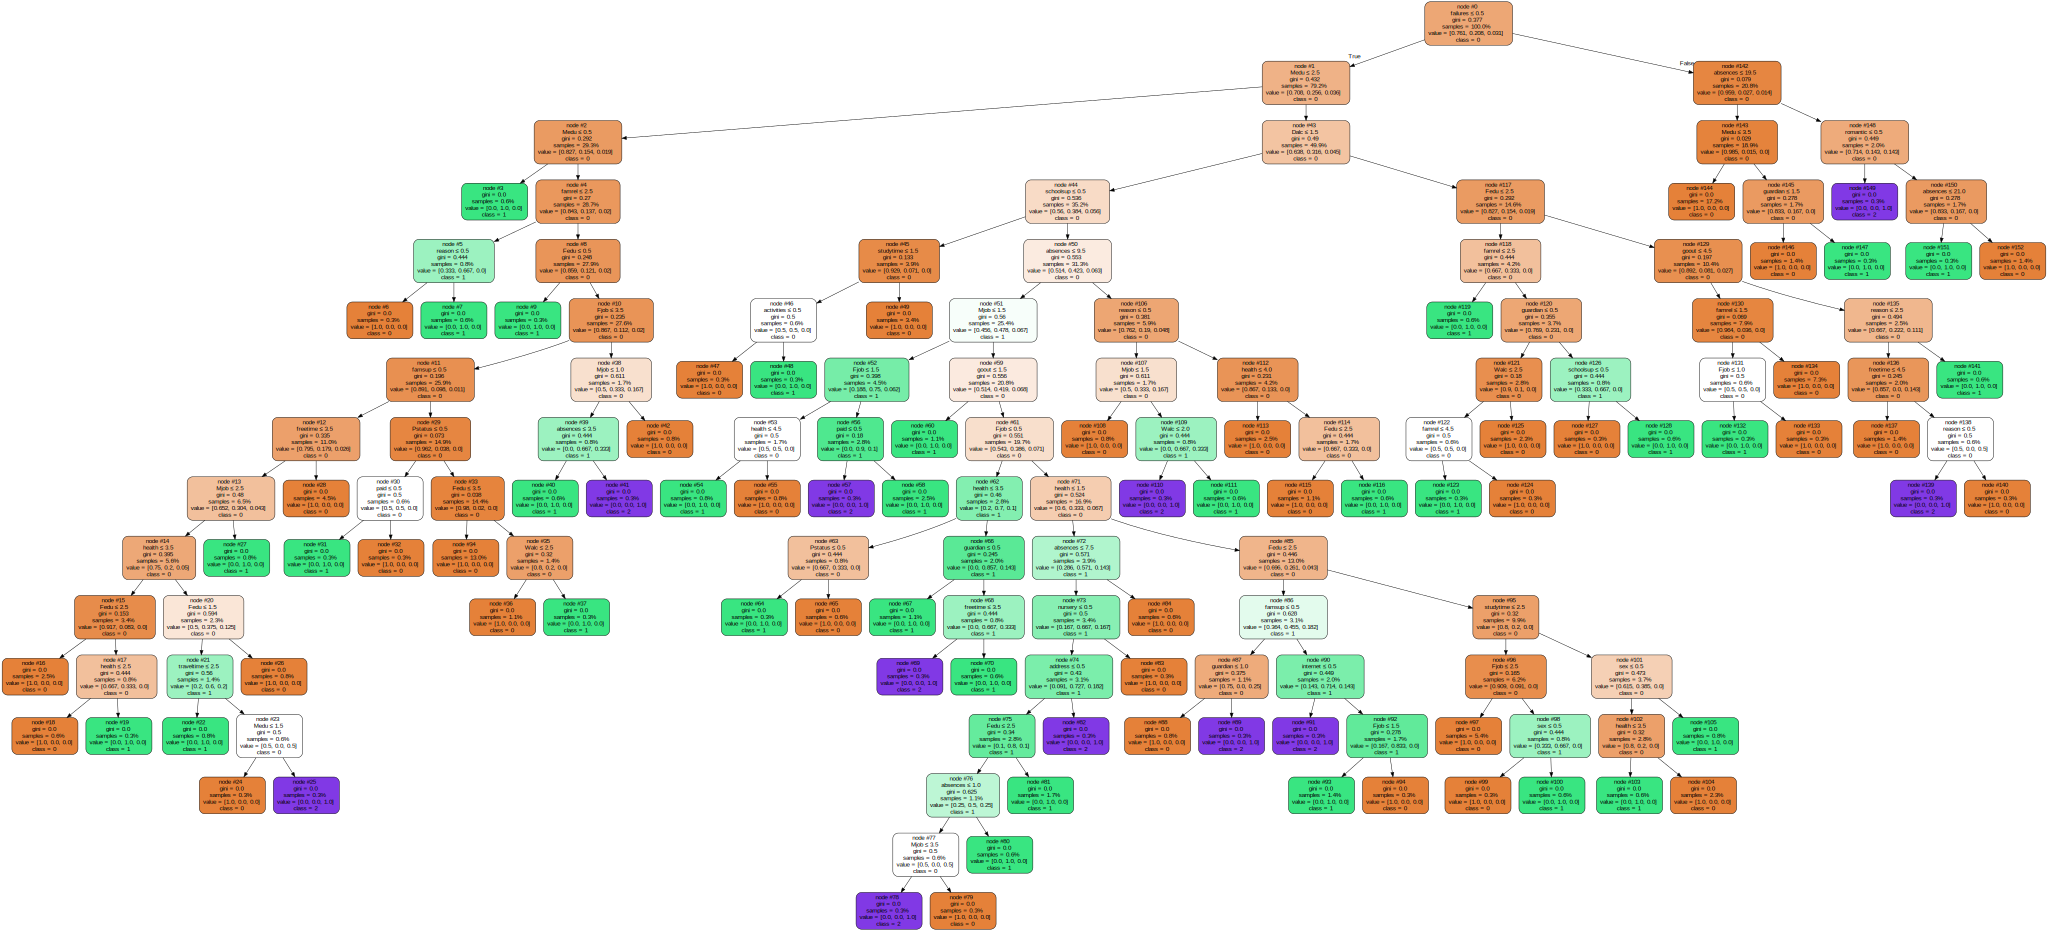

In [23]:
dot_data = export_graphviz(clf, 
                          out_file = None,
                          feature_names = student_features,
                          class_names = ['0','1','2'],
                          filled = True, rounded = True,
                          proportion = True,
                          node_ids = True,
                          rotate = False,
                          label = 'all',
                          special_characters = True)
graph = graphviz.Source(dot_data)
graph

In [24]:
from ipywidgets import interactive
from IPython.display import SVG,display
from graphviz import Source

### Gerando árvore de forma interativa

In [25]:
x,y = df.drop(columns=['gradesTypes', 'gradeAv', 'G1', 'G2', 'G3']), df['gradesTypes']
class_label = ['0','1','2']

def plot_tree(crit, split, depth, min_samples_split, min_samples_leaf = 0.2):
    estimator = DecisionTreeClassifier(
                                        random_state = 0
                                        ,criterion = crit
                                        ,splitter = split
                                        ,max_depth = depth
                                        ,min_samples_split = min_samples_split
                                        ,min_samples_leaf = min_samples_leaf)
    estimator.fit(x,y)
    graph = Source(export_graphviz(estimator,
                                  out_file = None
                                  ,feature_names=student_features
                                  ,class_names = class_label
                                  ,impurity = True
                                  ,filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter = interactive(plot_tree
                 ,crit = ['gini','entropy']
                 ,split = ['best','random']
                 ,depth = [1,2,3,4,5,10,20,30]
                 ,min_samples_split = (1,5)
                 ,min_samples_leaf = (1,5))
display(inter)
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### 5 - Extraindo Regras da árvore

In [26]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, np.argmax(tree_.value[node][0])))

    recurse(0, 1)

In [27]:
#Imprimindo conjunto de regras da árvore
tree_to_code(clf, student_features)

def tree(sex, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health, absences):
  if failures <= 0.5:
    if Medu <= 2.5:
      if Medu <= 0.5:
        return 1
      else:  # if Medu > 0.5
        if famrel <= 2.5:
          if reason <= 0.5:
            return 0
          else:  # if reason > 0.5
            return 1
        else:  # if famrel > 2.5
          if Fedu <= 0.5:
            return 1
          else:  # if Fedu > 0.5
            if Fjob <= 3.5:
              if famsup <= 0.5:
                if freetime <= 3.5:
                  if Mjob <= 2.5:
                    if health <= 3.5:
                      if Fedu <= 2.5:
                        return 0
                      else:  # if Fedu > 2.5
                        if health <= 2.5:
                          return 0
                        else:  # if hea